In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.7 MB/s eta 0:00:00


In [2]:
from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# TSP Environment

In [3]:
class TSP(gym.Env):
    """Traveling Salesman Problem (TSP) RL environment for persistent monitoring.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets in the least number of steps, with rewards determined by the distance traveled.
    """

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): Number of targets the agent needs to visit.
            max_area (int): Max Square area where the targets are defined. Defaults to 30
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        super().__init__()
        if seed is not None:
            np.random.seed(seed=seed)

        self.steps: int = 0
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: np.ndarray = self._generate_points(self.num_targets)
        self.distances: np.ndarray = self._calculate_distances(self.locations)

        # Observation Space
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),
                np.zeros(self.num_targets, dtype=np.float32),
                np.zeros(2 * self.num_targets, dtype=np.float32),
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),
            ]
        )

        # Action Space
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0

        self.loc: int = 0
        self.visited_targets: List = []
        self.clocks: np.ndarray = np.zeros(self.num_targets)
        self.dist: List = self.distances[self.loc]

        state = np.concatenate(
            (
                np.array([self.loc]),
                np.array(self.clocks),
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(
        self, action: int
    ) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action
        self.visited_targets.append(next_loc)

        self.distances[self.loc, next_loc]

        reward = self._get_rewards(past_loc, next_loc)

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> np.ndarray:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        points = []

        # Generate 2D points 10x10 grid
        while len(points) < num_points:
            x = np.random.random() * self.max_area
            y = np.random.random() * self.max_area
            if [x, y] not in points:
                points.append([x, y])

        return np.array(points)

    def _calculate_distances(self, locations: List) -> float:
        """Calculate the distance matrix between all target locations.

        Args:
            locations (List): List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, past_loc: int, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            past_loc (int): Previous location of the agent.
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        if next_loc not in self.visited_targets:
            reward = -self.distances[past_loc][next_loc]
        else:
            reward = -10000
        return reward

# Dynamic Programming

In [ ]:
if __name__ == "__main__":
    env = TSP(50) #Target being 50 cities
    disc_factor, learning_rate, num_episodes = 0.95, 0.1, 1000
    Q = np.zeros((env.num_targets, env.num_targets))

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = int(state[0])

        done = False
        while not done:
            action = np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = int(next_state[0])

            Q[state, action] += learning_rate * (reward + disc_factor * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            done = terminated or truncated

        if episode % 200 == 0:
            print(f"Episode {episode}, Q-values: {Q}")

    print("Optimal Policy:", np.argmax(Q, axis=1))


Episode 0, Q-values: [[-1000. -1000. -1000. ...     0.     0.     0.]
 [-1000.     0.     0. ...     0.     0.     0.]
 [-1000.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]]
Episode 200, Q-values: [[-6895.8706381  -6581.5541625  -6519.2246625  ... -6519.2246625
  -6456.5488875  -6469.049415  ]
 [-4525.42857494 -3970.099875   -3714.025      ... -3970.099875
  -3970.8715125  -3978.1817625 ]
 [-3294.922125   -3970.099875   -3970.099875   ... -3970.099875
  -3970.099875   -2993.1475    ]
 ...
 [-3294.922125   -3970.099875   -3970.099875   ... -3970.099875
  -2994.004875   -3010.249875  ]
 [-3364.177125   -3970.099875   -3970.099875   ... -3970.099875
  -3970.099875   -2993.1475    ]
 [-3574.985925   -3970.099875   -3970.099875   ... -3241.099875
  -3970.099875   -3970.099875  ]]
Episode 400, Q-values: [[-10729.08403731 -10538.7216394  -11086.030

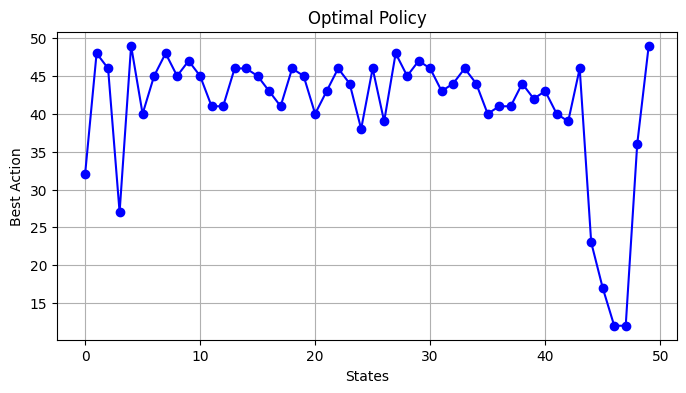

In [4]:
# Function to plot the optimal policy
def visualize_policy(policy):
    plt.figure(figsize=(8, 4))
    plt.plot(policy, marker='o', linestyle='-', color='b')
    plt.title('Optimal Policy')
    plt.xlabel('States')
    plt.ylabel('Best Action')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = TSP(50)
    disc_factor, learning_rate, num_episodes = 0.95, 0.1, 1000
    Q = np.zeros((env.num_targets, env.num_targets))

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = int(state[0])

        done = False
        while not done:
            action = np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = int(next_state[0])

            Q[state, action] += learning_rate * (reward + disc_factor * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            done = terminated or truncated

    # After convergence, extract and visualize the best policy
    policy = np.argmax(Q, axis=1)
    visualize_policy(policy)
